In [23]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms
import scipy.stats

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)
    
def makeROCPlot(pred,true,label="",noSkill=True,color=None):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    if color is None: plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    else: plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc),color=color)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL",color="grey",linestyle="--")
    plt.legend()
    return auc

def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3,color="black"):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

In [2]:
#importlib.reload(PeakDetective)

In [3]:
resolution = 60
window = 1.0
align = True

In [4]:
#yeast 
datadir = "D:/PeakDetective/data/yeast_spike_in/"
ms1ppm = 5
peakWidth = (18,65)
s2n = 10
noise = 100
mzDiff = 0.01
prefilter = 1
cutoff = 0.6 #default cutoff from last run

In [5]:
rawDataDir = datadir + "tmp/"

In [6]:
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
#det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
#peakList = peakList[["mz","rt"]]
peakList

,mz,rt,rt_start,rt_end,12C_yeast_dil5_neg_ID_01.mzML,12C_yeast_dil5_neg_ID_02.mzML,12C_yeast_dil5_neg_ID_03.mzML
FT00001,67.018874,2.546730,2.546730,2.546730,2.591714e+04,2.796900e+04,2.664059e+04
FT00002,67.341881,7.056295,7.052210,7.059298,2.429768e+05,2.323133e+05,2.413477e+05
FT00003,67.905278,8.354074,8.349439,8.383592,2.958427e+05,2.730634e+05,3.862521e+04
FT00004,68.995637,0.909700,0.905593,0.951474,3.300720e+06,2.927774e+06,3.107247e+06
FT00005,69.034467,3.661305,3.650539,3.700464,2.481073e+05,2.749766e+05,2.808135e+05
...,...,...,...,...,...,...,...
FT10270,892.718360,7.848364,7.848119,7.848609,4.538124e+04,5.312517e+04,4.364067e+04
FT10271,894.771158,11.763599,11.763599,11.763599,3.057795e+04,0.000000e+00,0.000000e+00
FT10272,895.238025,11.498061,11.498061,11.498061,5.115163e+04,5.777569e+04,2.565410e+04
FT10273,897.089314,11.498061,11.490762,11.499579,1.626249e+05,1.263556e+05,1.140157e+05


In [7]:
spikeins = pd.read_csv(datadir + "peaks_spiked_refined.csv",index_col=0)
print(len(spikeins))
spikeins

58


,mz,rt,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
Molecule Name,,,,,,
"Fructose 1,6-bisphosphate",338.988774,8.91,NaN,NaN,NaN,NaN
Citric acid,191.019727,8.94,NaN,NaN,NaN,NaN
Acetyl-CoA,808.118499,6.04,NaN,NaN,NaN,NaN
cis-Aconitate,173.009162,8.67,NaN,NaN,NaN,NaN
CMP-sialic acid,613.139992,8.34,NaN,NaN,NaN,NaN
Fructose,179.056112,4.89,NaN,NaN,NaN,NaN
Glucose,179.056112,6.14,NaN,NaN,NaN,s
N-Acetylglucosamine 1-phosphate,300.048992,7.03,NaN,NaN,NaN,NaN
CYCLIC AMP,328.045244,2.28,NaN,NaN,NaN,NaN


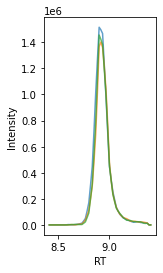

In [30]:
for index,row in spikeins.iterrows():
    plt.figure(figsize=(2,4))
    plot_overlayedEIC(raw_data,row["mz"],row["rt"]-.5,row["rt"]+.5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    break
    

In [8]:
merged_feats,merged_inds = detection_helper.mergePeakLists([peakList,spikeins],["xcms feats","spike ins"],ms1ppm,0.1)
sharedInds = merged_feats[(merged_feats["xcms feats"] > 0.5) & (merged_feats["spike ins"] > 0.5)]["xcms feats"].values
print(len(sharedInds))
peakList = peakList[~peakList.index.isin(sharedInds)]
peakList

46


,mz,rt,rt_start,rt_end,12C_yeast_dil5_neg_ID_01.mzML,12C_yeast_dil5_neg_ID_02.mzML,12C_yeast_dil5_neg_ID_03.mzML
FT00001,67.018874,2.546730,2.546730,2.546730,2.591714e+04,2.796900e+04,2.664059e+04
FT00002,67.341881,7.056295,7.052210,7.059298,2.429768e+05,2.323133e+05,2.413477e+05
FT00003,67.905278,8.354074,8.349439,8.383592,2.958427e+05,2.730634e+05,3.862521e+04
FT00004,68.995637,0.909700,0.905593,0.951474,3.300720e+06,2.927774e+06,3.107247e+06
FT00005,69.034467,3.661305,3.650539,3.700464,2.481073e+05,2.749766e+05,2.808135e+05
...,...,...,...,...,...,...,...
FT10270,892.718360,7.848364,7.848119,7.848609,4.538124e+04,5.312517e+04,4.364067e+04
FT10271,894.771158,11.763599,11.763599,11.763599,3.057795e+04,0.000000e+00,0.000000e+00
FT10272,895.238025,11.498061,11.498061,11.498061,5.115163e+04,5.777569e+04,2.565410e+04
FT10273,897.089314,11.498061,11.490762,11.499579,1.626249e+05,1.263556e+05,1.140157e+05


In [10]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['12C_yeast_dil5_neg_ID_01.mzML', '12C_yeast_dil5_neg_ID_02.mzML', '12C_yeast_dil5_neg_ID_03.mzML']


In [11]:
integ = PeakDetective.PeakDetective(numCores = 20,resolution=resolution)

In [35]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X = integ.makeDataMatrix(raw_data,peakList["mz"],rts,align=align)
    

forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 


In [36]:
pkl.dump([X],open(datadir + "model_selection_data.pkl","wb"))

In [12]:
[X] = pkl.load(open(datadir + "model_selection_data.pkl","rb"))

In [38]:
if __name__ == "__main__":
    integ.trainSmoother(peakList,raw_data,100000,10,64,0.1)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/10
1407/1407 [==============================] - 87s 61ms/step - loss: 0.1631 - mean_absolute_error: 0.0762 - val_loss: 0.0832 - val_mean_absolute_error: 0.0062
Epoch 2/10
1407/1407 [==============================] - 76s 54ms/step - loss: 0.0813 - mean_absolute_error: 0.0049 - val_loss: 0.0801 - val_mean_absolute_error: 0.0039
Epoch 3/10
1407/1407 [==============================] - 72s 51ms/step - loss: 0.0799 - mean_absolute_error: 0.0035 - val_loss: 0.0796 - val_mean_absolute_error: 0.0034
Epoch 4/10
1407/1407 [==============================] - 73s 52ms/step - loss: 0.0796 - mean_absolute_error: 0.0032 - val_loss: 0.0794 - val_mean_absolute_error: 0.0031
Epoch 5/10
1407/1407 [==============================] - 74s 53ms/step - loss: 0.0795 - mean_absolute_error: 0.0030 - val_loss: 0.0792 - val_mean_absolute_error: 0.0029
Epoch 6/10
1407/1407 [==================

In [39]:
integ.save(datadir + "smoothed_only/")

In [40]:
integ.load(datadir + "smoothed_only/")

1/1 [==============================] - 0s 24ms/step
loss: 0.3497759699821472 mean_absolute_error: 0.2046602964401245 val loss: 0.26696309447288513 val_mean_absolute_error: 0.15671221911907196 numEpochs: 455
960/960 [==============================] - 1s 1ms/step


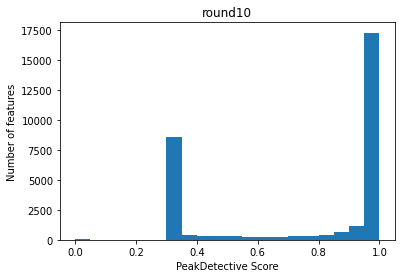

30712 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


1/1 [==============================] - 0s 37ms/step


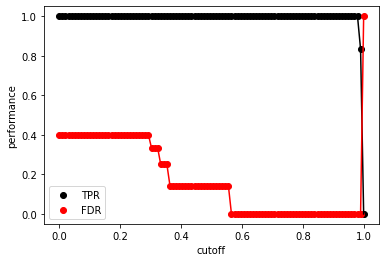

In [41]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,[],[],200,1000,4,1,numVal = 10,numManualPerRound=10,inJupyter=True)

In [43]:
integ.save(datadir + "active/")

In [13]:
integ.load(datadir + "active/")

In [14]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,spikeins,threshold=cutoff,align=align)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
6/6 [==============================] - 0s 1ms/step
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 


In [15]:
cols = [x for x in peak_curated.columns.values if ".mzML" in x]
cols

['D:/PeakDetective/data/yeast_spike_in/12C_yeast_dil5_neg_ID_01.mzML',
 'D:/PeakDetective/data/yeast_spike_in/12C_yeast_dil5_neg_ID_02.mzML',
 'D:/PeakDetective/data/yeast_spike_in/12C_yeast_dil5_neg_ID_03.mzML']

In [21]:
numKeptSpike = []
for col in cols:
    numCor = 0
    for index,row in peak_curated.iterrows():
        if row[col] > 0.5:
            numCor += 1
    numKeptSpike.append(numCor/len(peak_curated))
    print(numCor,numCor/len(peak_curated)) 

49 0.8448275862068966
49 0.8448275862068966
48 0.8275862068965517


In [17]:
if __name__ == "__main__":
    peak_curated_all,peak_scores_all,peak_intensities_all = integ.curatePeaks(raw_data,peakList,threshold=cutoff,align=align)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
964/964 [==============================] - 1s 1ms/step
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 


In [22]:
numKeptAll = []
for col in cols:
    numCor = 0
    for index,row in peak_curated_all.iterrows():
        if row[col] > 0.5:
            numCor += 1
    numKeptAll.append(numCor/len(peak_curated_all))
    print(numCor,numCor/len(peak_curated_all)) 

6815 0.6633248978002725
6895 0.6711115437025501
6881 0.6697488806696515


In [27]:
100*np.mean(numKeptAll),100*np.std(numKeptAll),100*np.mean(numKeptSpike),100*np.std(numKeptSpike)

(66.80617740574914, 0.33953605741226894, 83.9080459770115, 0.8127664151569527)

In [25]:
scipy.stats.ttest_ind(numKeptAll,numKeptSpike)

Ttest_indResult(statistic=-27.45762495468098, pvalue=1.0463302656290322e-05)

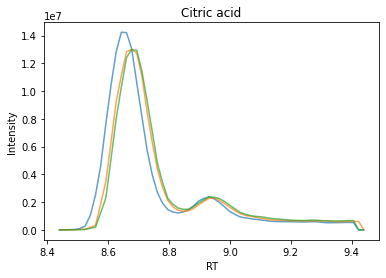

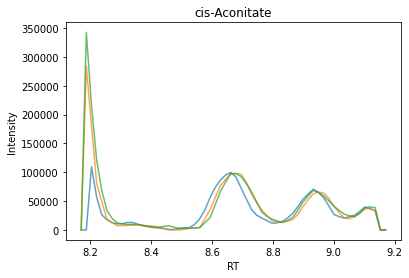

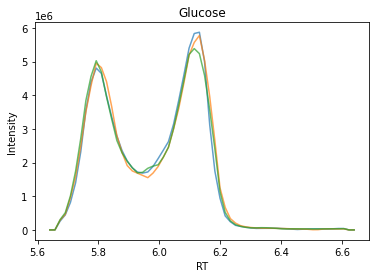

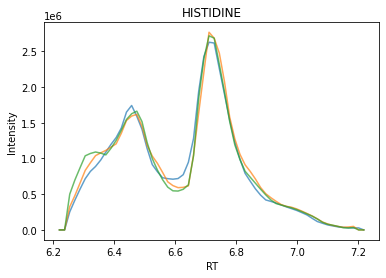

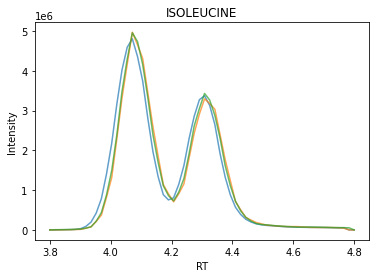

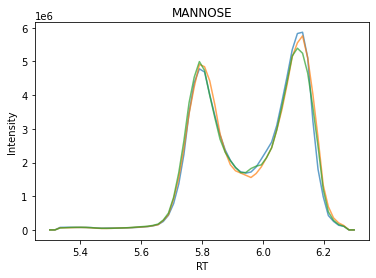

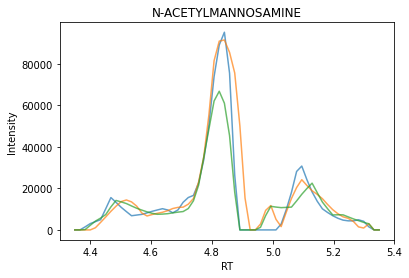

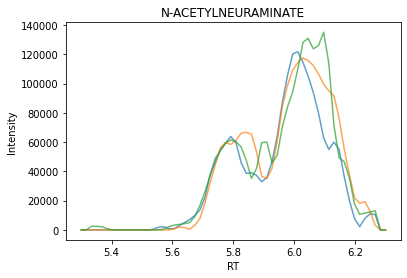

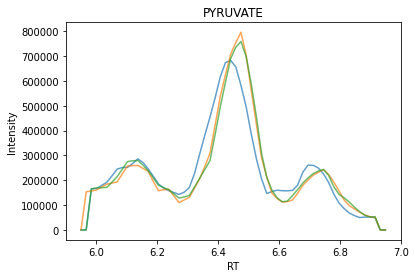

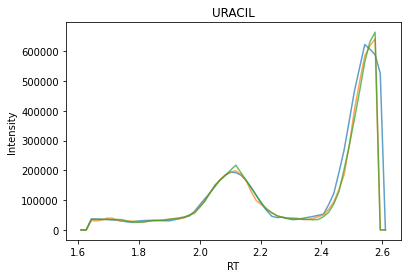

In [75]:
for index,row in peak_curated.iterrows():
    if np.sum(row[cols]) < 2.5:
        plt.figure()
        plot_overlayedEIC(raw_data,row["mz"],row["rt"]-.5,row["rt"] + .5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        plt.title(index)


C:\Users\Ethan\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


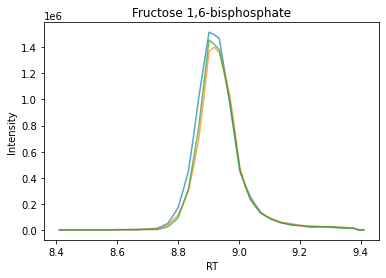

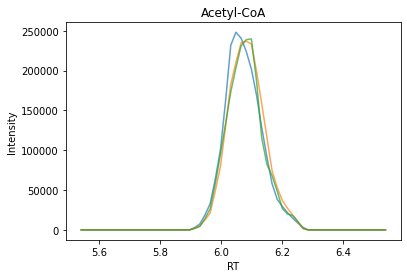

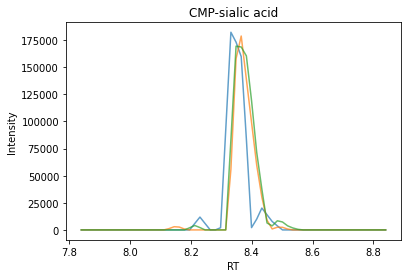

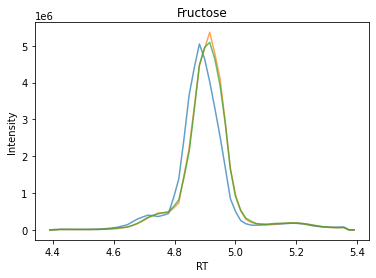

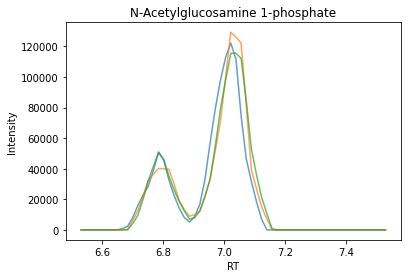

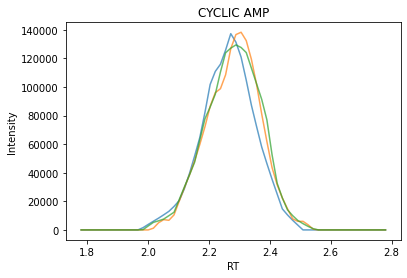

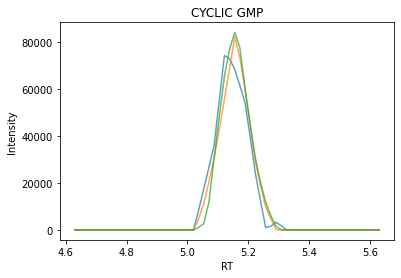

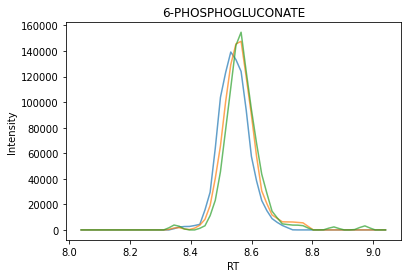

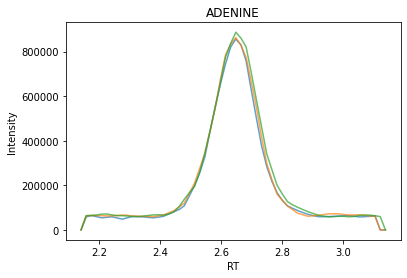

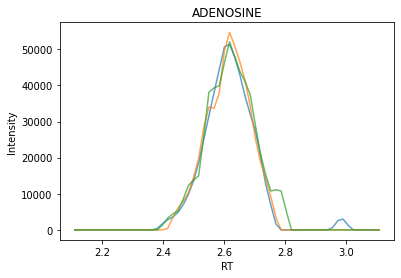

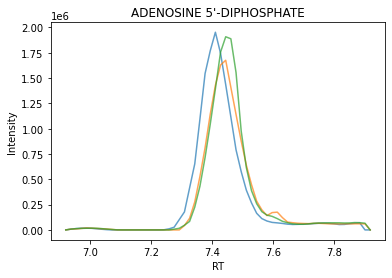

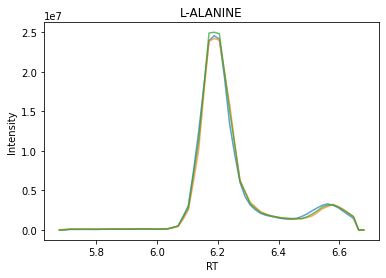

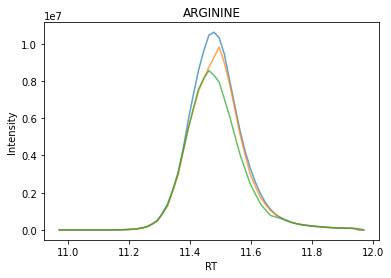

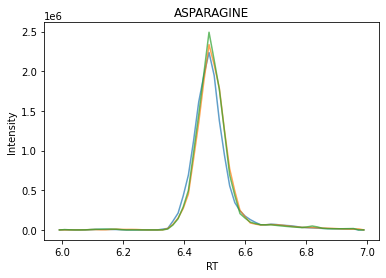

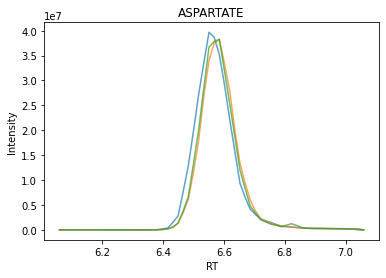

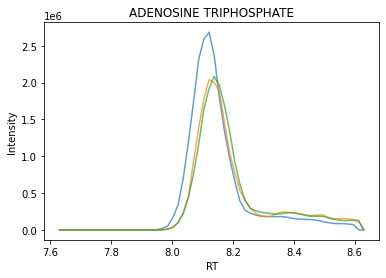

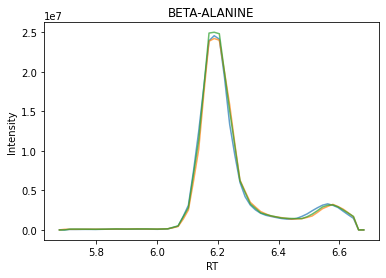

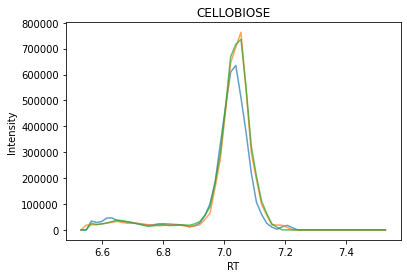

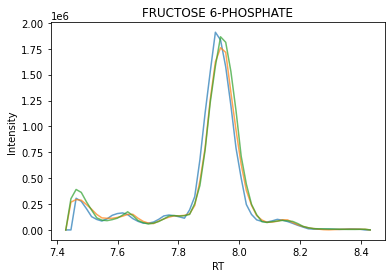

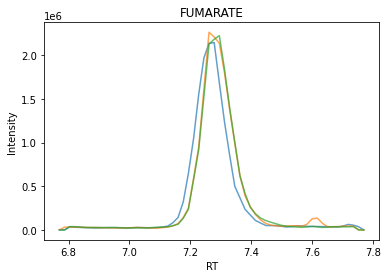

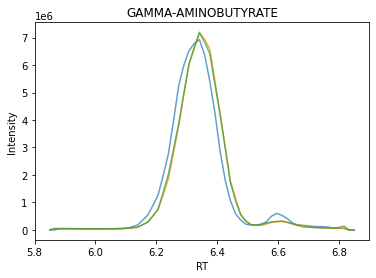

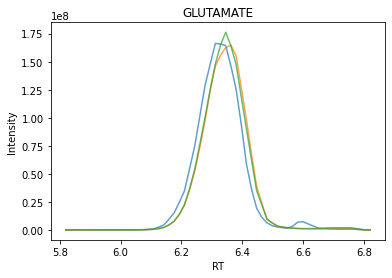

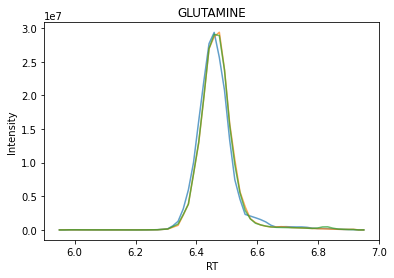

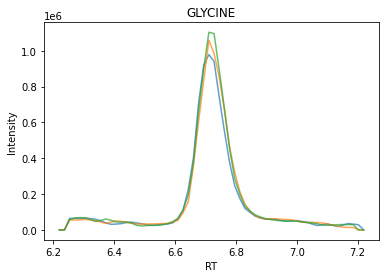

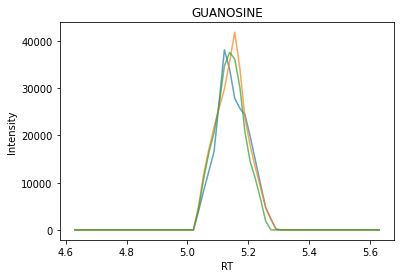

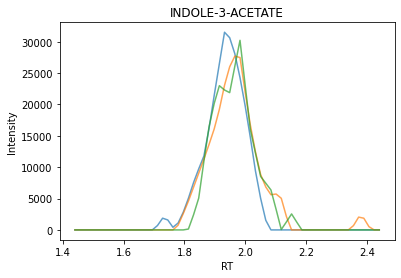

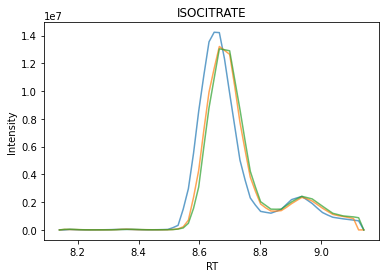

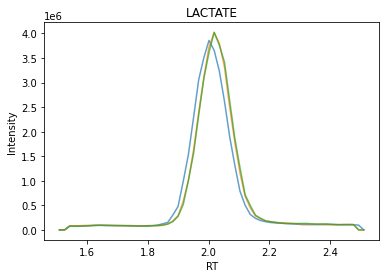

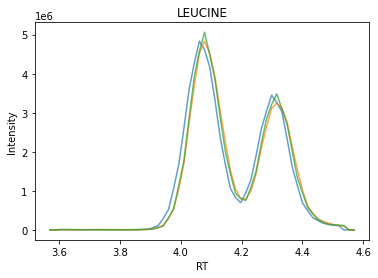

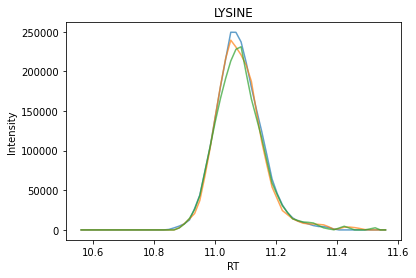

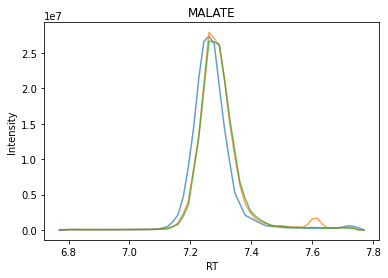

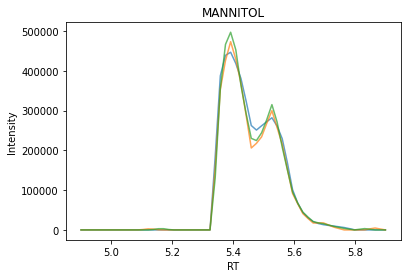

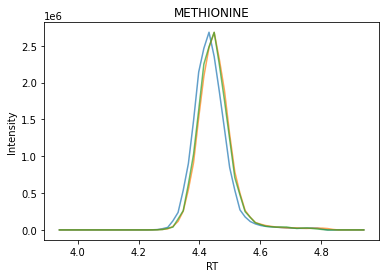

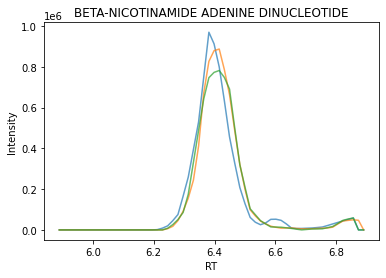

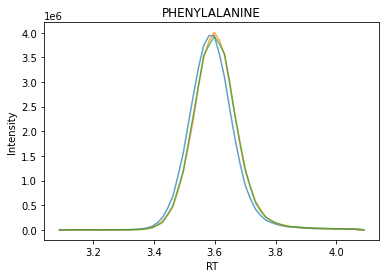

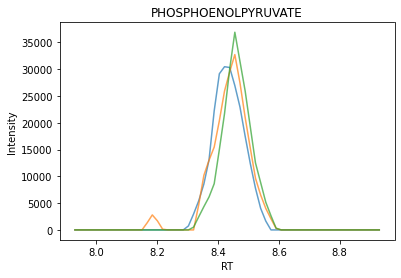

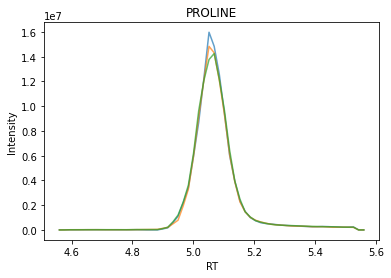

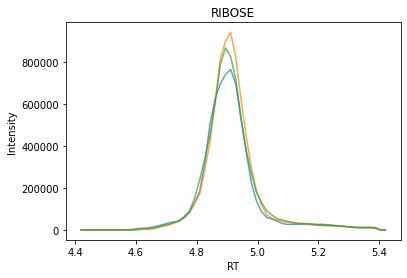

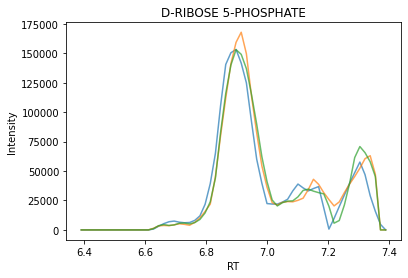

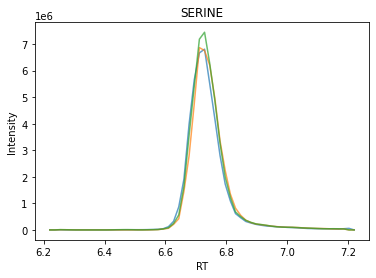

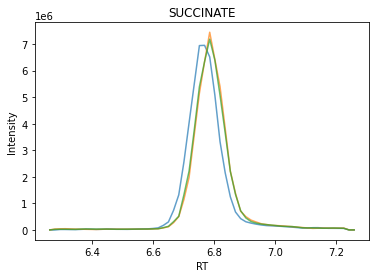

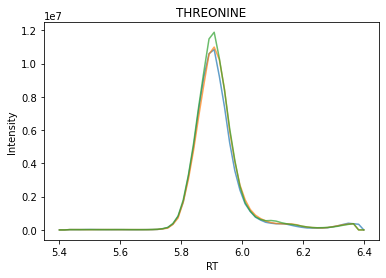

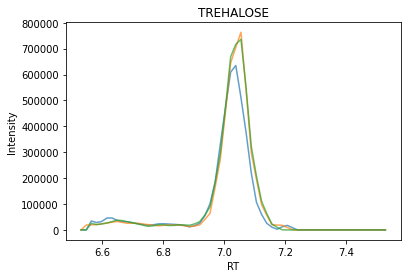

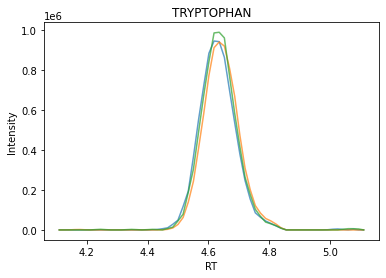

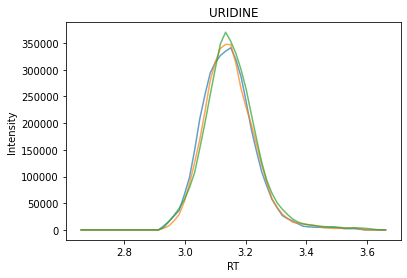

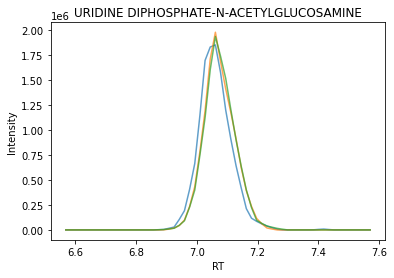

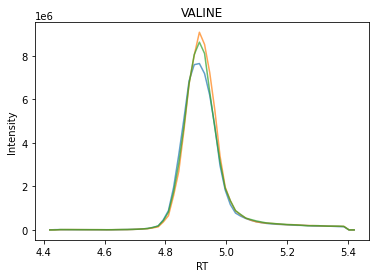

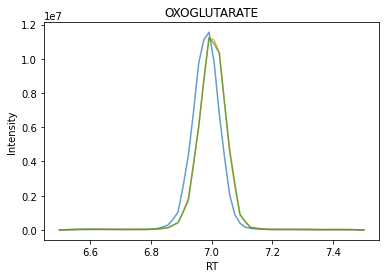

In [76]:
for index,row in peak_curated.iterrows():
    if np.sum(row[cols]) > 2.5:
        plt.figure()
        plot_overlayedEIC(raw_data,row["mz"],row["rt"]-.5,row["rt"] + .5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        plt.title(index)
